# REPL-граф
В этом ноутбуке мы создадим базового агента на langgraph, который может решать задачи пользователя с помощью написания кода.
Агент, действует по шагам, поэтому может:
1. Работать с файлами без предварительной загрузки информации о них в промпт: сначала узнает какие в файле есть колонки, потом итеративно выполняет задачу
2. Исправлять ошибки, если они возникнут при выполнении его кода

Для запуска кода, мы будем использовать [E2B](https://e2b.dev/)

---

## Подготовка к запуску

Перед выполнением ноутбука необходимо установить следующие библиотеки:

In [71]:
%%capture --no-stderr
%pip install langchain_gigachat python-dotenv langgraph e2b-code-interpreter

---

## Инициализация подключения GigaChat

In [77]:
import getpass
import os
from dotenv import load_dotenv

load_dotenv()

if "GIGACHAT_CREDENTIALS" not in os.environ and "GIGACHAT_USER" not in os.environ:
    os.environ["GIGACHAT_CREDENTIALS"] = getpass.getpass("Credentials от GigaChat")
    
if "E2B_API_KEY" not in os.environ:
    os.environ["E2B_API_KEY"] = getpass.getpass("Токен от E2B")

scope = "GIGACHAT_API_PERS" # Возможно также: GIGACHAT_API_CORP / GIGACHAT_API_B2B

In [78]:
from langchain_gigachat import GigaChat

llm = GigaChat(
    model="GigaChat-2-Max",
    verify_ssl_certs=False,
    scope=scope,
)

---
## Создаем REPL-цепочку

In [79]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

CODE_PROMPT = ChatPromptTemplate.from_messages([
    ("system", """Ты — Senior Python Developer с глубоким пониманием технологического стека и библиотек Python. Твоя задача — решить
    проблему пользователя, предоставив чистый, оптимизированный и профессионально оформленный код.

Требования к коду:
- Выполнение кода: Чтобы выполнить код, который ты присылаешь, оборачивай его в markdown тег ```python-execute\n```
- Качество кода: Твой код должен следовать стандартам PEP8.
- Обработка ошибок: Если в исполнении кода возникла ошибка, необходимо её исправить и предоставить исправленный вариант кода.
- Визуализация данных: Используй `matplotlib` для всех графических представлений данных.
- Импорты: Начни свой код с четкого и корректного блока импортов.
- Типы данных: Следи за корректным преобразованием типов данных в своих операциях.
- Формат ответа: Отвечай на запросы пользователя, используя markdown для оформления.
- Результат выполнения: Ответы должны базироваться только на выводах, полученных в результате выполнения кода.
- Показывание изображение: Ни в коем случае не сохраняй изображения, а показывай их в формате Jupyter ноутбуков

Эти требования помогут обеспечить качество твоего кода и его соответствие современным стандартам разработки.

Как ты решаешь задачи:
Решай задачу по простым шагам!
Если у тебя не хватает данных, например ты не знаешь названия колонок в файле,
то сначала напиши код, который открывает файл и выводит информацию из файла.
Потом не пиши ничего и жди, что в результате выполнения тебе вернет код.
После этого переходи к следующему шагу"""),
    MessagesPlaceholder("messages")
])

code_ch = CODE_PROMPT | llm

---
## Создаем граф
В нашем графе будут 3 ноды:
* **agent** — вызов LLM с вопросом пользователя / результатами выполнения кода
* **code** — выполнение кода и создания сообщения о результатах выполнения
* **final_answer** — финальный ответ на вопрос пользователя исходя из истории сообщений

In [98]:
from e2b_code_interpreter import Sandbox
from langgraph.graph import END, StateGraph, MessagesState
from langchain_core.messages import HumanMessage
import re

PYTHON_REGEX = r"```python-execute(.+?)```"

sandbox = Sandbox()


def should_continue(state: MessagesState) -> str:
    last_message = state['messages'][-1]
    # Если GigaChat вернул python-execute переходим в ноду выполнения кода
    # Если нет, то заканчиваем выполнение
    if re.findall(PYTHON_REGEX, last_message.content, re.DOTALL | re.MULTILINE):
        return "code"
    else:
        return "final_answer"
    

def extract_text_from_results(results):
    """Извлечение текста из результатов выполнения кода"""
    return "\n".join([result.text for result in results if result.text])

def extract_images_from_results(results):
    """Извлечение изображений из результатов выполнения кода"""
    return "\n".join(["*В результате выполнения кода был сгенерирован график*" for result in results if result.chart])

def call_model(state: MessagesState):
    """Вызов LLM"""
    response = code_ch.invoke({"messages": state["messages"]})
    return {"messages": response}

def final_answer(state: MessagesState):
    question = ""
    for mes in reversed(state["messages"]):
        if mes.type == "human" and "executions" not in mes.additional_kwargs:
            question = mes.content
    response = code_ch.invoke({
        "messages": state["messages"] + [
            HumanMessage(content=f"Ответь на вопрос пользователя: \"{question}\", используя полученную информацию выше.")
        ]
    })
    return {"messages": response}
    


def execute_code(state: MessagesState):
    """Выполнение кода"""
    messages = state['messages']
    code_blocks = re.findall(PYTHON_REGEX, messages[-1].content, re.DOTALL | re.MULTILINE)
    results = []
    executions = []
    for index, code_block in enumerate(code_blocks):
        execution = sandbox.run_code(code_block)
        executions.append(execution)
        if execution.error:
            results.append(f"""В результате выполнения блока {index} возникла ошибка:
```
{execution.error.traceback}
```
Исправь ошибку""")
            break
        else:
            logs = '\n'.join(execution.logs.stdout)
            results.append(f"""Результат выполнения блока {index}:
```
{logs} {extract_text_from_results(execution.results)} {extract_images_from_results(execution.results)}
```""")
    message = HumanMessage(content="\n".join(results), additional_kwargs={"executions": executions})
    return {"messages": message}

# Определяем граф
workflow = StateGraph(MessagesState)
workflow.add_node("agent", call_model)
workflow.add_node("code", execute_code)
workflow.add_node("final_answer", final_answer)

workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("code", "agent")
workflow.add_edge("final_answer", END)

workflow.set_entry_point("agent")

app = workflow.compile()

---
## Примеры работы
### Получение текущего курса доллара
**Заметьте!** — текущий граф может выполняться очень долго в течении 12 шагов. С помощью параметра **recursion_limit** мы ограничиваем выполнение до 5 шагов. 

In [89]:
from base64 import b64decode
from IPython.core.display import Image
from IPython.display import display

for values in app.stream(
        {"messages": [("user", "Найди текущий курс доллара с помощью CBR")]},
    config={"recursion_limit": 10},
    stream_mode="values",
):
    values["messages"][-1].pretty_print()
    if "executions" in values["messages"][-1].additional_kwargs:
        executions = values["messages"][-1].additional_kwargs["executions"]
        for execution in executions:
            for result in execution.results:
                if result.png:
                    display(Image(b64decode(result.png)))

================================ Human Message =================================

Найди текущий курс доллара с помощью CBR
================================== Ai Message ==================================

Для получения курса доллара с сайта Центрального банка России (CBR) можно воспользоваться API или парсингом HTML страницы. Но поскольку сайт предоставляет удобный XML формат для курсов валют, лучше использовать именно этот способ.

Чтобы извлечь данные о курсе валюты, воспользуемся модулем `requests` для работы с HTTP-запросами и модулем `xml.etree.ElementTree` для обработки XML.

Вот пример реализации:

```python-execute
import requests
from xml.etree import ElementTree as ET

# URL для запроса текущих курсов валют от ЦБ РФ
url = 'http://www.cbr.ru/scripts/XML_daily.asp'
response = requests.get(url)

if response.status_code == 200:
    # Парсим ответ как XML-документ
    root = ET.fromstring(response.content)
    
    # Находим элемент с USD (Валюта США имеет ID "R01235")
    usd_ele

### Создание графика с ценой доллара за 30 дней

================================ Human Message =================================

Нарисуй график цены доллара за последние 30 дней используя информацию с cbr
================================== Ai Message ==================================

Для построения графика курса доллара за последние 30 дней воспользуемся API Центрального банка России (cbr). 

Вот пример кода, который выполнит эту задачу:

```python-execute
import requests
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Функция получения курсов валют от ЦБ РФ
def get_currency_rates(start_date, end_date):
    url = f"http://www.cbr.ru/scripts/XML_dynamic.asp?date_req1={start_date}&date_req2={end_date}&VAL_NM_RQ=R01235"
    response = requests.get(url)
    
    if response.status_code == 200:
        from xml.etree import ElementTree as ET
        
        root = ET.fromstring(response.content)
        data_points = []
        
        for record in root.findall('Record'):
            date_str = record.at

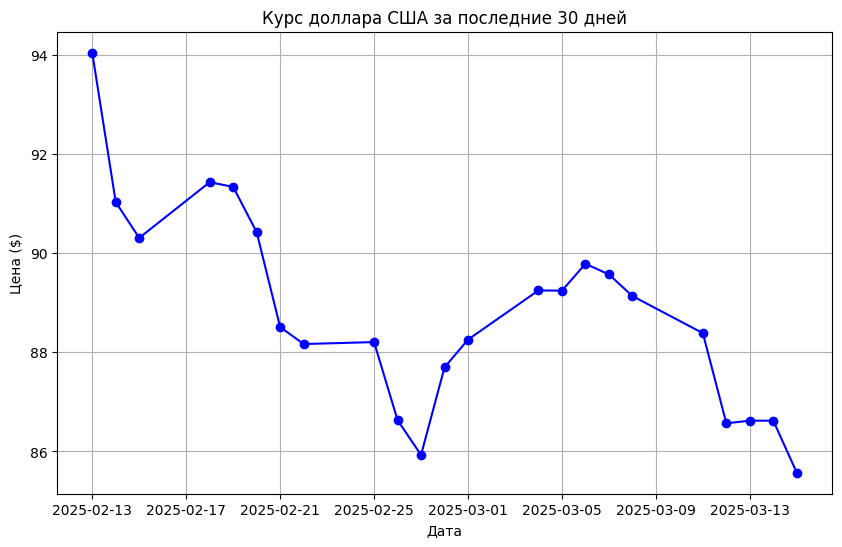

================================== Ai Message ==================================

Отличная новость! Это означает, что график успешно построен и отображен. Он показывает динамику курса доллара за последние 30 дней.

**График включает следующие элементы:**
- Заголовок "Курс доллара США за последние 30 дней".
- Ось X содержит даты за указанный период времени.
- Ось Y представляет цену доллара в рублях.
- На графике видна линия тренда, которая соединяет точки цен за каждый день, а также сами значения курсовых котировок отмечены маркерами.

Этот график позволяет визуально оценить колебания курса доллара за последний месяц.
================================== Ai Message ==================================

### График курса доллара за последние 30 дней

На основе информации, полученной через API Центрального Банка России (ЦБ РФ), я построил график изменения курса доллара США за последние 30 дней. Этот график наглядно демонстрирует динамику стоимости американской валюты относительно российского 

In [99]:
from base64 import b64decode
from IPython.core.display import Image
from IPython.display import display

for values in app.stream(
        {"messages": [("user", "Нарисуй график цены доллара за последние 30 дней используя информацию с cbr")]},
    config={"recursion_limit": 10},
    stream_mode="values",
):
    values["messages"][-1].pretty_print()
    if "executions" in values["messages"][-1].additional_kwargs:
        executions = values["messages"][-1].additional_kwargs["executions"]
        for execution in executions:
            for result in execution.results:
                if result.png:
                    display(Image(b64decode(result.png)))

### Работа с файлами

In [103]:
# Загружаем локальный файл
with open("sales.xlsx", "rb") as file:
	sandbox.files.write("/home/user/sales.xlsx", file)

================================ Human Message =================================

С помощью файла sales.xlsx сделай график среднего чека за год
================================== Ai Message ==================================

```python-execute
import pandas as pd
import matplotlib.pyplot as plt

# Загружаем данные из Excel-файла
df = pd.read_excel('sales.xlsx')
print(df.head())
```

Этот код загрузит первые 5 строк данных из файла 'sales.xlsx' и выведет их содержимое. Это поможет понять структуру данных перед построением графика среднего чека за год.
================================ Human Message =================================

Результат выполнения блока 0:
```
        Месяц  Электроника  Одежда  Мебель  Игрушки  Книги  \
0  2024-01-01         1023     850     421      932    345   
1  2024-02-01         1130     910     392      989    376   
2  2024-03-01         1210    1002     410     1005    389   
3  2024-04-01         1105     970     387      960    378   
4  2024-05-01    

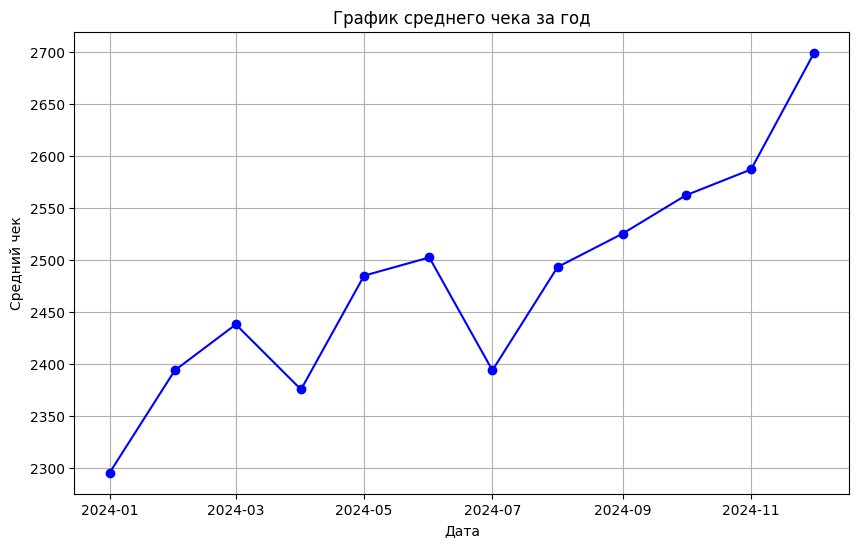

================================== Ai Message ==================================

Теперь график успешно построен! Он отображает изменение среднего чека за каждый месяц.

### Важные моменты:
- **Тип данных:** Мы конвертировали строку с датой в объект `datetime`, чтобы правильно упорядочить месяцы на графике.
- **Форматирование:** График настроен так, чтобы было удобно видеть динамику среднего чека по каждому месяцу. 

Вы можете дополнительно настроить внешний вид графика или добавить дополнительные метрики при необходимости. Например, вы могли бы добавить линии трендов или более сложные вычисления.

---

**Примечание**: При выполнении кода, как упоминалось ранее, результат представлен в виде графика без сохранения изображений, поскольку они сразу же визуализируются в интерактивной среде, такой как Jupyter Notebook.
================================== Ai Message ==================================

Чтобы ответить на запрос пользователя о создании графика среднего чека за год с использовани

In [104]:
from base64 import b64decode
from IPython.core.display import Image
from IPython.display import display

for values in app.stream(
        {"messages": [("user", "С помощью файла sales.xlsx сделай график среднего чека за год")]},
    config={"recursion_limit": 10},
    stream_mode="values",
):
    values["messages"][-1].pretty_print()
    if "executions" in values["messages"][-1].additional_kwargs:
        executions = values["messages"][-1].additional_kwargs["executions"]
        for execution in executions:
            for result in execution.results:
                if result.png:
                    display(Image(b64decode(result.png)))